In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import xgboost as xgb
import seaborn as sns

In [2]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_features.csv")

In [3]:
train_data.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [4]:
# 觀察資料後發現一個看起來不像人名，另一個則是全都是 NAN
train_data =  train_data[(train_data['name'] != "THE TRAVEL AGENCY IN THE PARK") & (train_data['name'] != "LOCKHART EUGENE E")]

In [5]:
train_data.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [6]:
train_data.shape

(111, 22)

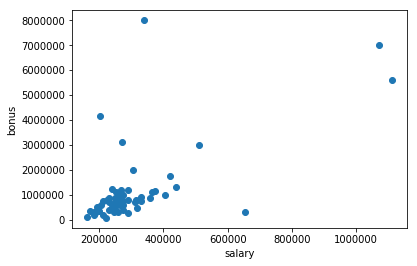

In [7]:
# Scatter plot for salary & bonus, 看起來左上跟右下有兩個 outlier
plt.scatter(train_data['salary'] , train_data['bonus'])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [8]:
train_data[(train_data['bonus'] == 8000000)]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
33,LAVORATO JOHN J,8000000.0,NaN,NaN,NaN,john.lavorato@enron.com,4158995.0,49537.0,2585.0,528.0,...,2035380.0,1552.0,False,1008149.0,NaN,339288.0,3962.0,7259.0,10425757.0,5167144.0


In [9]:
train_data[(train_data['bonus'] <1000000) & (train_data['salary'] > 600000)]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
110,PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,...,NaN,NaN,False,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0


In [10]:
# 刪除 outlier
train_data =  train_data[(train_data['name'] != "PICKERING MARK R") & (train_data['name'] != "LAVORATO JOHN J")]

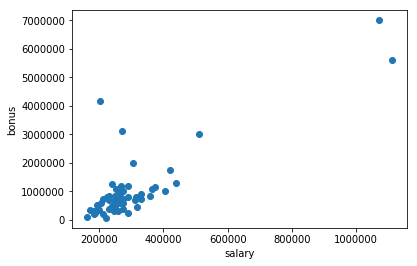

In [11]:
plt.scatter(train_data['salary'] , train_data['bonus'])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [12]:
train_data.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,5.900000e+01,2.800000e+01,3.400000e+01,13.000000,7.900000e+01,71.000000,63.000000,63.000000,63.000000,1.0,4.800000e+01,6.700000e+01,8.100000e+01,10.000000,7.100000e+01,63.000000,63.000000,9.300000e+01,9.600000e+01
mean,1.045655e+06,6.344374e+05,-4.625664e+05,89397.846154,3.007642e+06,51334.788732,691.809524,58.365079,34.841270,81525000.0,7.667262e+05,4.550984e+05,1.298394e+06,-221885.700000,2.676135e+05,1072.206349,2095.031746,2.543648e+06,3.546493e+06
std,1.229302e+06,8.603646e+05,8.095392e+05,41143.391399,6.069945e+06,48214.949360,2092.524250,71.795251,76.717371,NaN,9.428988e+05,1.360570e+06,2.513694e+06,205191.374121,1.677330e+05,1126.082320,2776.910298,1.070286e+07,7.247355e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,12.000000,0.000000,0.000000,81525000.0,7.102300e+04,2.000000e+00,4.409300e+04,-560222.000000,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.750000e+05,7.656750e+04,-5.527032e+05,101250.000000,4.066780e+05,17674.000000,19.000000,10.000000,0.000000,81525000.0,2.750000e+05,9.595000e+02,2.640130e+05,-389621.750000,2.040380e+05,152.500000,510.500000,2.497870e+05,4.282172e+05
50%,7.500000e+05,1.951900e+05,-1.175340e+05,108579.000000,8.500100e+05,41953.000000,44.000000,28.000000,7.000000,81525000.0,3.987310e+05,5.238200e+04,4.623840e+05,-139856.500000,2.501000e+05,589.000000,1088.000000,1.101393e+06,9.979710e+05
75%,1.000000e+06,8.342052e+05,-2.708325e+04,112492.000000,2.117739e+06,61483.000000,180.500000,81.000000,26.000000,81525000.0,8.142118e+05,3.653800e+05,9.567750e+05,-77953.250000,2.885500e+05,1874.500000,2648.000000,1.979596e+06,2.493616e+06
max,7.000000e+06,2.964506e+06,-1.042000e+03,125034.000000,3.434838e+07,228763.000000,14368.000000,305.000000,387.000000,81525000.0,5.145434e+06,1.035973e+07,1.476169e+07,44093.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 112
Data columns (total 22 columns):
name                         109 non-null object
bonus                        59 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
email_address                81 non-null object
exercised_stock_options      79 non-null float64
expenses                     71 non-null float64
from_messages                63 non-null float64
from_poi_to_this_person      63 non-null float64
from_this_person_to_poi      63 non-null float64
loan_advances                1 non-null float64
long_term_incentive          48 non-null float64
other                        67 non-null float64
poi                          109 non-null bool
restricted_stock             81 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       71 non-null float64
shared_receipt_wi

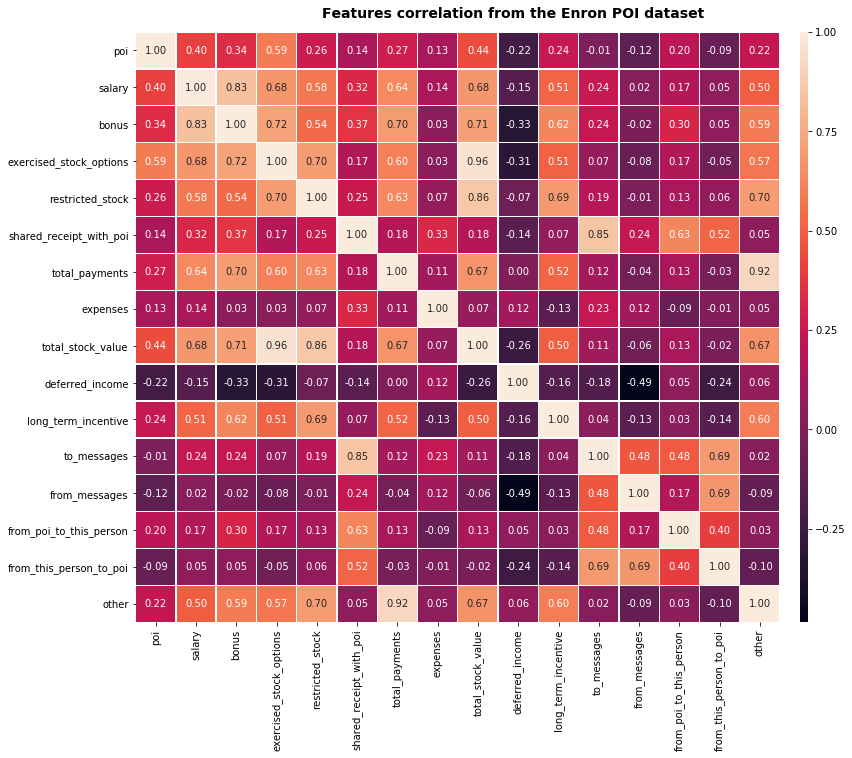

In [14]:
allFeatures = ['poi','salary','bonus', 'exercised_stock_options', 'restricted_stock', 'shared_receipt_with_poi',
               'total_payments', 'expenses', 'total_stock_value', 'deferred_income', 'long_term_incentive',
               'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other']

train_data = train_data[allFeatures]
test_data = test_data[allFeatures[1:]]

correlationDataframe = train_data.corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws)

## 新增傳送/收到 poi 信件 的比例 features

In [15]:
train_data['portion_from_poi'] = train_data['from_poi_to_this_person'] / train_data['from_messages']
train_data['portion_to_poi'] = train_data['from_this_person_to_poi'] / train_data['to_messages']

train_data['portion_from_poi'] = train_data['portion_from_poi'].fillna(0)
train_data['portion_to_poi'] = train_data['portion_to_poi'].fillna(0)

In [16]:
test_data['portion_from_poi'] = test_data['from_poi_to_this_person'] / test_data['from_messages']
test_data['portion_to_poi'] = test_data['from_this_person_to_poi'] / test_data['to_messages']

test_data['portion_from_poi'] = test_data['portion_from_poi'].fillna(0)
test_data['portion_to_poi'] = test_data['portion_to_poi'].fillna(0)

In [17]:
train_data['ratio_exercised_restricted'] = train_data['exercised_stock_options'] / train_data['restricted_stock'] 
test_data['ratio_exercised_restricted'] = test_data['exercised_stock_options'] / test_data['restricted_stock'] 

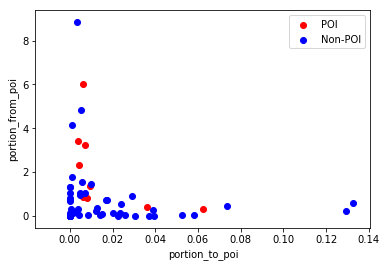

In [18]:
is_poi = (True, False)
colors = ('r', "b")
groups = ("POI", "Non-POI")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for poi, color, group in zip(is_poi, colors, groups):
    data_plot = train_data[train_data['poi'] == poi]
    ax.scatter(data_plot['portion_to_poi'], data_plot['portion_from_poi'], c=color, label=group)
plt.xlabel("portion_to_poi")
plt.ylabel("portion_from_poi")
plt.legend(loc=1)
plt.show()

## 建立 X_train, y_train 資料

In [19]:
x_train = train_data.drop(['poi'], axis=1)
y_train = train_data['poi']

In [20]:
x_train = x_train.fillna(0) 

## 訓練模型

In [21]:
# 建立模型
clf = xgb.XGBClassifier()

In [22]:
n_estimators = [600, 800, 1000]
max_depth = [2, 4, 6]
scale_pos_weight = [0.4, 1, 1.5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, scale_pos_weight=scale_pos_weight)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=1 )

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    4.4s finished
/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
grid_result.best_params_

{'max_depth': 4, 'n_estimators': 600, 'scale_pos_weight': 0.4}

In [24]:
# # 使用最佳參數重新建立模型
clf_bestparam = xgb.XGBClassifier(max_depth=grid_result.best_params_['max_depth'],
                                  n_estimators=grid_result.best_params_['n_estimators'],
                                  scale_pos_weight=grid_result.best_params_['scale_pos_weight'])

# 訓練模型
clf_bestparam.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4, seed=None,
       silent=True, subsample=1)

In [25]:
x_test = test_data.fillna(0) 

In [26]:
y_test = pd.read_csv('test_label.csv')['poi']

In [27]:
y_pred = clf_bestparam.predict_proba(x_test)[:,1]

In [28]:
print("AUC: ", roc_auc_score(y_test, y_pred))

AUC:  0.9000000000000001


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text yticklabel objects>)

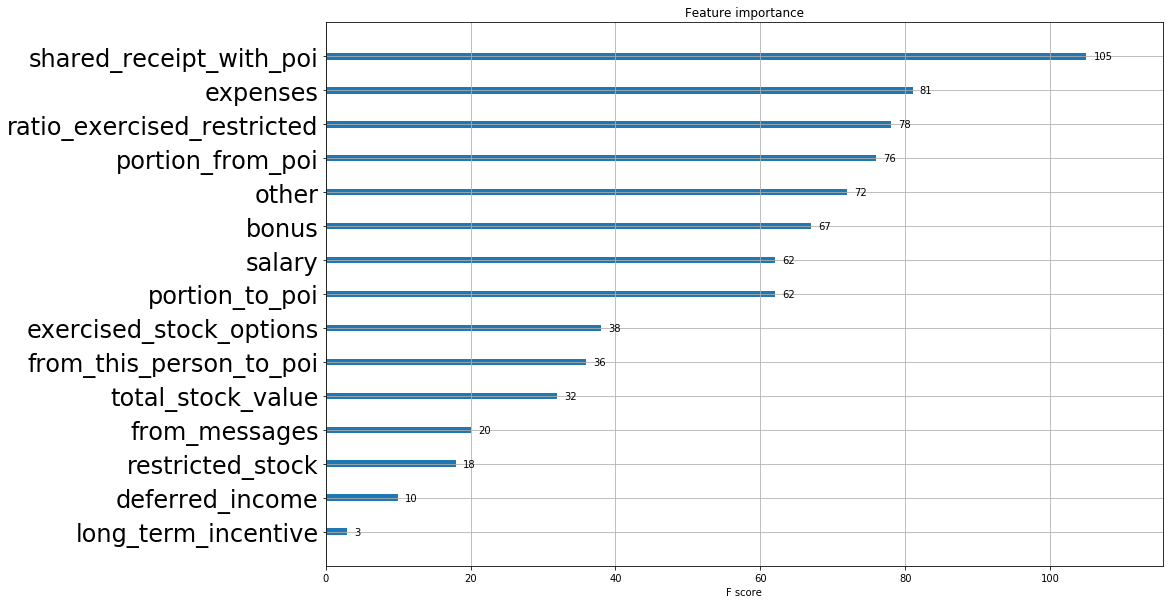

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(clf_bestparam, ax=ax, ylabel=None)
plt.yticks(size=24)